In [1]:
from osgeo import gdal
import pandas as pd
import geopandas as gp
from matplotlib import pyplot as plt
from matplotlib import colors
from shapely.geometry import Point
import py7zr
import cudf

# 1. Import files from Google Drive and extract them into data folder

In [2]:
import gdown
# Google drive public shared folder ID
id = "1vdm8b0ewDslPVvubA8emwDYHUGtwx5pT"
gdown.download_folder(id=id,output="../data", quiet=True, use_cookies=False)

['../data/bike_data.7z']

In [3]:
import py7zr
# Extract files from 7zip file
with py7zr.SevenZipFile('../data/bike_data.7z', mode='r') as z:
    z.extractall("../data")

## 2. Read files

In [4]:
df = pd.read_csv('../data/accidentsVelo.csv', low_memory=False,decimal=',')
df.head()

Num_Acc        date    an     mois      jour   hrmn dep    com  \
0  200500000030  2005-01-13  2005  janvier     jeudi  19:45  62  62331   
1  200500000034  2005-01-19  2005  janvier  mercredi  10:45  62  62022   
2  200500000078  2005-01-26  2005  janvier  mercredi  13:15  02  02173   
3  200500000093  2005-01-03  2005  janvier     lundi  13:30  02  02810   
4  200500000170  2005-01-29  2005  janvier    samedi  18:30  76  76196   

      lat   long  ...  secuexist  equipement  obs  obsm  choc  manv  \
0    50.3   2.84  ...          0           0  0.0   2.0   8.0  11.0   
1       0      0  ...          0           0  0.0   2.0   1.0   1.0   
2       0      0  ...          1           2  0.0   2.0   1.0   1.0   
3  49.255  3.094  ...          0           0  0.0   2.0   3.0  21.0   
4       0      0  ...          1           9  0.0   2.0   4.0   2.0   

        vehiculeid  typevehicules  manoeuvehicules  numVehicules  
0  200500000030B02             18               17           1.0  
1  200500000034B02             10               15           1.0  
2  200500000078B02              7               15           1.0  
3  200500000093B02              7               21           1.0  
4  200500000170A01             10                2           1.0  

[5 rows x 39 columns]

# Removing NA's on lat and long long columns only

In [5]:
num_rows = len(df)
df = df.dropna(subset=['lat','long'])
num_rows_not_na = len(df)
print("Num of rows before removing NA's : %d..After : %d" % (num_rows,num_rows_not_na) )

Num of rows before removing NA's : 74758..After : 74490


# Check column types and convert if necessary

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74490 entries, 0 to 74757
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Num_Acc          74490 non-null  int64  
 1   date             74490 non-null  object 
 2   an               74490 non-null  int64  
 3   mois             74490 non-null  object 
 4   jour             74490 non-null  object 
 5   hrmn             74490 non-null  object 
 6   dep              74490 non-null  object 
 7   com              74490 non-null  object 
 8   lat              74490 non-null  object 
 9   long             74490 non-null  object 
 10  agg              74490 non-null  int64  
 11  int              74490 non-null  int64  
 12  col              74486 non-null  float64
 13  lum              74490 non-null  int64  
 14  atm              74488 non-null  float64
 15  catr             74490 non-null  int64  
 16  circ             74347 non-null  float64
 17  nbv         

In [7]:
df['lat'] = df['lat'].apply(lambda x: float(str(x).split()[0].replace(',', '.')))
df['lat'] = df['lat'].astype(float)

df['long'] = df['long'].apply(lambda x: float(str(x).split()[0].replace(',', '.')))
df['long'] = df['long'].astype(float)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74490 entries, 0 to 74757
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Num_Acc          74490 non-null  int64  
 1   date             74490 non-null  object 
 2   an               74490 non-null  int64  
 3   mois             74490 non-null  object 
 4   jour             74490 non-null  object 
 5   hrmn             74490 non-null  object 
 6   dep              74490 non-null  object 
 7   com              74490 non-null  object 
 8   lat              74490 non-null  float64
 9   long             74490 non-null  float64
 10  agg              74490 non-null  int64  
 11  int              74490 non-null  int64  
 12  col              74486 non-null  float64
 13  lum              74490 non-null  int64  
 14  atm              74488 non-null  float64
 15  catr             74490 non-null  int64  
 16  circ             74347 non-null  float64
 17  nbv         

# Checking zeros on lat and long cols and total number of cols

In [9]:
count_lat = df['lat'].value_counts()[0]
count_long = df['long'].value_counts()[0]
rows = len(df)

results = pd.DataFrame(data={"lat_with_zero":[count_lat], "long_with_zero":[count_long],"Total number of rows": [rows]})
results

lat_with_zero  long_with_zero  Total number of rows
0          42084           43131                 74490

# Extract rows where lat and long are not 0

In [10]:
df_filtered = df.loc[(df['lat'] != 0) & (df['long'] != 0)].copy()
print("Filterd data frame has %d rows" %(len(df_filtered)))

Filterd data frame has 31355 rows


# Converting to geodataframe

epsg:4326


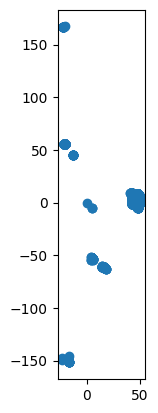

In [11]:
# Convert longitude and latitude to a geometric Point object
points_gdf = gp.GeoDataFrame(df_filtered, geometry=gp.points_from_xy(df_filtered.lat, df_filtered.long))
# Convert DataFrame to GeoDataFrame
points_gdf = points_gdf.set_crs('epsg:4326')
points_gdf.plot(aspect='equal')
print(points_gdf.crs)

# Its seems the coordinates are inverted, let's fix this

epsg:27561


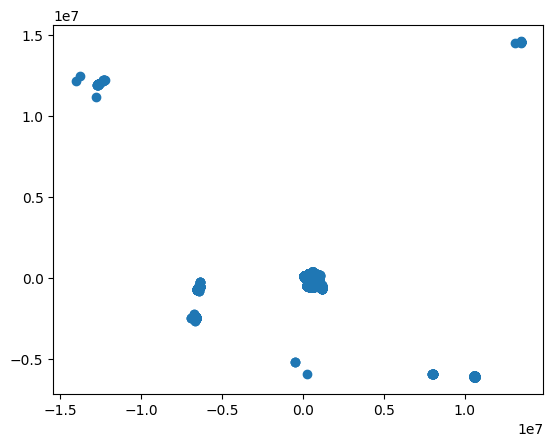

In [12]:
# Convert longitude and latitude to a geometric Point object
points_gdf = gp.GeoDataFrame(df_filtered, geometry=gp.points_from_xy(df_filtered.long, df_filtered.lat))
# Convert DataFrame to GeoDataFrame
points_gdf = points_gdf.set_crs('epsg:4326').to_crs('epsg:27561')
points_gdf.plot()
print(points_gdf.crs)

# Check the number of 0 on lat and long columns

In [13]:
points_gdf.head()

Num_Acc        date    an     mois   jour   hrmn dep    com     lat  \
0   200500000030  2005-01-13  2005  janvier  jeudi  19:45  62  62331  50.300   
3   200500000093  2005-01-03  2005  janvier  lundi  13:30  02  02810  49.255   
6   200500000260  2005-01-04  2005  janvier  mardi  16:45  22  22143  48.590   
10  200500000291  2005-01-24  2005  janvier  lundi  17:30  56  56155  47.485   
14  200500000329  2005-01-04  2005  janvier  mardi  19:00  50  50213  49.086   

     long  ...  equipement  obs  obsm  choc  manv       vehiculeid  \
0   2.840  ...           0  0.0   2.0   8.0  11.0  200500000030B02   
3   3.094  ...           0  0.0   2.0   3.0  21.0  200500000093B02   
6  -2.300  ...           0  0.0   2.0   1.0   5.0  200500000260B02   
10 -2.467  ...           2  0.0   2.0   3.0  15.0  200500000291B02   
14 -1.092  ...           0  0.0   2.0   4.0  13.0  200500000329B02   

    typevehicules  manoeuvehicules  numVehicules  \
0              18               17           1.0   
3               7               21           1.0   
6               7                1           1.0   
10              7                1           1.0   
14              7                2           1.0   

                         geometry  
0   POINT (635873.910 289101.859)  
3   POINT (655137.321 173039.590)  
6   POINT (258175.124 109337.357)  
10  POINT (238049.201 -12534.885)  
14  POINT (349671.489 159668.389)  

[5 rows x 40 columns]

# Plot France department limits and bike accident points

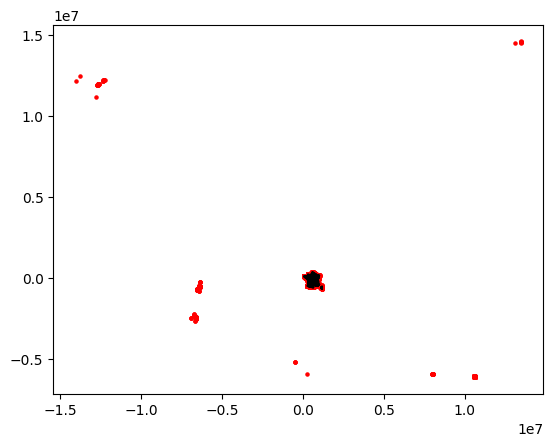

In [14]:
france_gdf = gp.read_file("../data/france_dep.geojson")
france_gdf = france_gdf.to_crs('epsg:27561')

ax = points_gdf.plot(marker='o', color='red', markersize=5,aspect=1)
france_gdf.plot(ax=ax, color='white', edgecolor='black')
plt.show();

# Let's grab only the points inside France and plot bicycle accident points together

In [15]:
points_within = gp.sjoin(points_gdf,france_gdf,predicate='within')

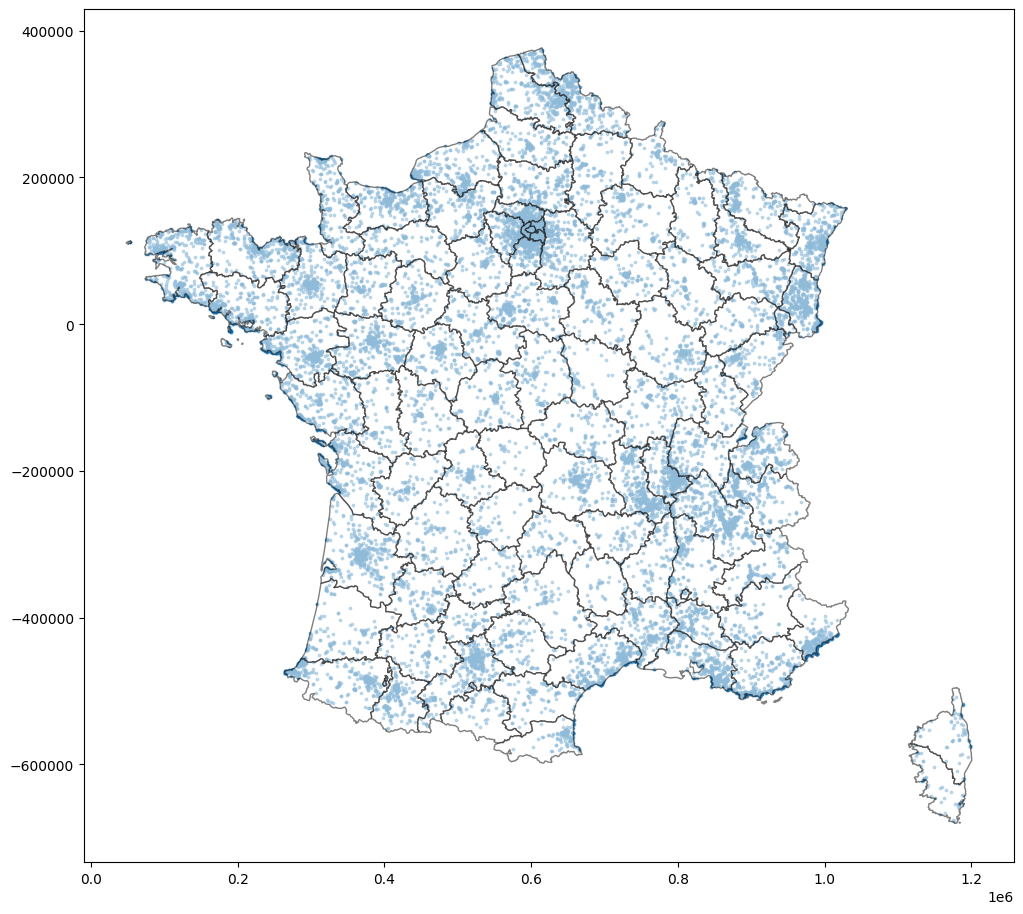

In [16]:
ax = points_within.plot(legend=True, markersize=3,alpha=0.5,figsize=(12,12))
france_gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor="k")
plt.show();

# Checking if the gravity of the accident can be spatially explained

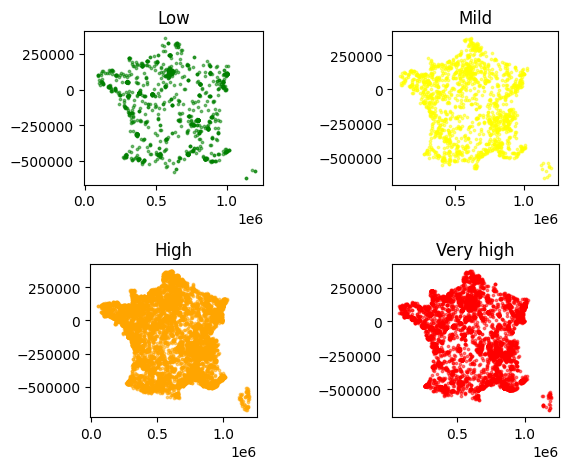

In [17]:
fig, axs = plt.subplots(2, 2)


points_within_grav_1 = points_within.loc[points_within['grav'] == 1]
points_within_grav_1.plot(ax=axs[0, 0],markersize=3,alpha=0.5,color='green')
axs[0, 0].set_title("Low")

points_within_grav_2 = points_within.loc[points_within['grav'] == 2]
points_within_grav_2.plot(ax=axs[0, 1],markersize=3,alpha=0.5,color='yellow')
axs[0, 1].set_title("Mild")

axs[1, 0].sharex(axs[0, 0])

points_within_grav_3 = points_within.loc[points_within['grav'] == 3]
points_within_grav_3.plot(ax=axs[1, 0],markersize=3,alpha=0.5,color='orange')
axs[1, 0].set_title("High")

points_within_grav_4 = points_within.loc[points_within['grav'] == 4]
points_within_grav_4.plot(ax=axs[1, 1],markersize=3,alpha=0.5,color='red')
axs[1, 1].set_title("Very high")

fig.tight_layout()


## It seems that the accidents of types are well distributed across the country and concentrated on major cities. Also, it may indicate that the gravity of an accident is subjective.

## Lets check the density of accidents (regardless of it's gravity) by region population

<Axes: >

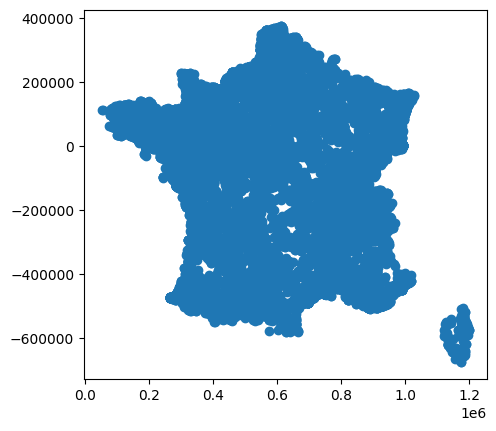

In [18]:
accidents_by_department = points_gdf.sjoin(france_gdf,predicate='within')
accidents_by_department.plot()

### Plot accidents by gravity and by department

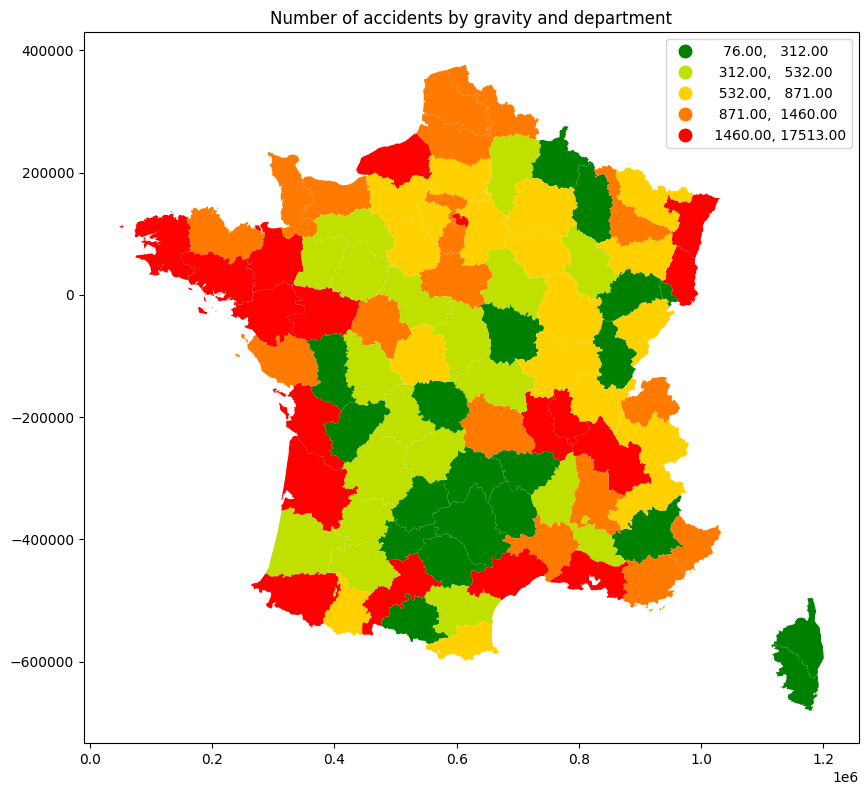

In [19]:
accidents_by_region = accidents_by_department.dissolve(by='nom', aggfunc='sum',numeric_only=False)

# Remove index field names
france_gdf=france_gdf.loc[:,~france_gdf.columns.str.startswith('index_')]
accidents_by_region=accidents_by_region.loc[:,~accidents_by_region.columns.str.startswith('index_')]

departments_by_accidents = gp.sjoin(france_gdf,accidents_by_region,how="inner",predicate="intersects")

cmap = colors.LinearSegmentedColormap.from_list("", ["green","yellow","orange","red"])

departments_by_accidents.plot(column = 'grav', scheme='quantiles', cmap=cmap,figsize=(10,10),legend=True);
plt.title("Number of accidents by gravity and department")
plt.show()

In [20]:
departments_by_accidents[["nom","grav"]].sort_values("grav",ascending=False)

nom   grav
36                  Paris  17513
82         Maine-et-Loire   3482
5         Ille-et-Vilaine   3112
33   Pyrénées-Atlantiques   2461
54                Gironde   2376
..                    ...    ...
81                    Lot    158
48           Corse-du-Sud    151
30                 Lozère    118
95  Territoire de Belfort    113
50                 Creuse     76

[96 rows x 2 columns]

### By using a quantilles representation, we  notice that touristic zones have a high number of accidents. But Paris, on absolute numbers, is still way higher than other departments

# Removing spaces and upper cases from cols of both dataframes

In [21]:
accidents_by_region.columns = [x.lower().replace(' ','') for x in accidents_by_region.columns]
accidents_by_department.columns = [x.lower().replace(' ','') for x in accidents_by_department.columns]

# Calculate the occurences of accidents by region and add this info to the geodataframe with polygons

In [22]:
num_accidents_per_region = pd.DataFrame({'total':accidents_by_department['nom'].value_counts()}).reset_index().rename(columns={'index': 'nom'})
num_accidents_per_region

nom  total
0                   Paris   5001
1          Maine-et-Loire    994
2         Ille-et-Vilaine    892
3                 Gironde    704
4    Pyrénées-Atlantiques    703
..                    ...    ...
91                    Lot     56
92           Corse-du-Sud     49
93  Territoire de Belfort     38
94                 Lozère     37
95                 Creuse     24

[96 rows x 2 columns]

In [23]:
# Merge
accidents_by_region_and_name = accidents_by_department.merge(num_accidents_per_region, on='nom')
region_by_accidents = france_gdf.merge(num_accidents_per_region, on='nom')

<Axes: >

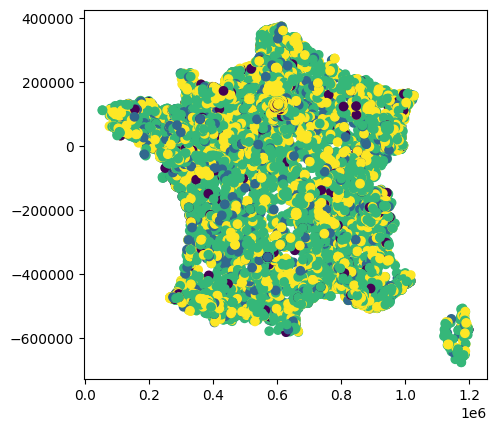

In [24]:
accidents_by_region_and_name.plot(column='grav')

<Axes: >

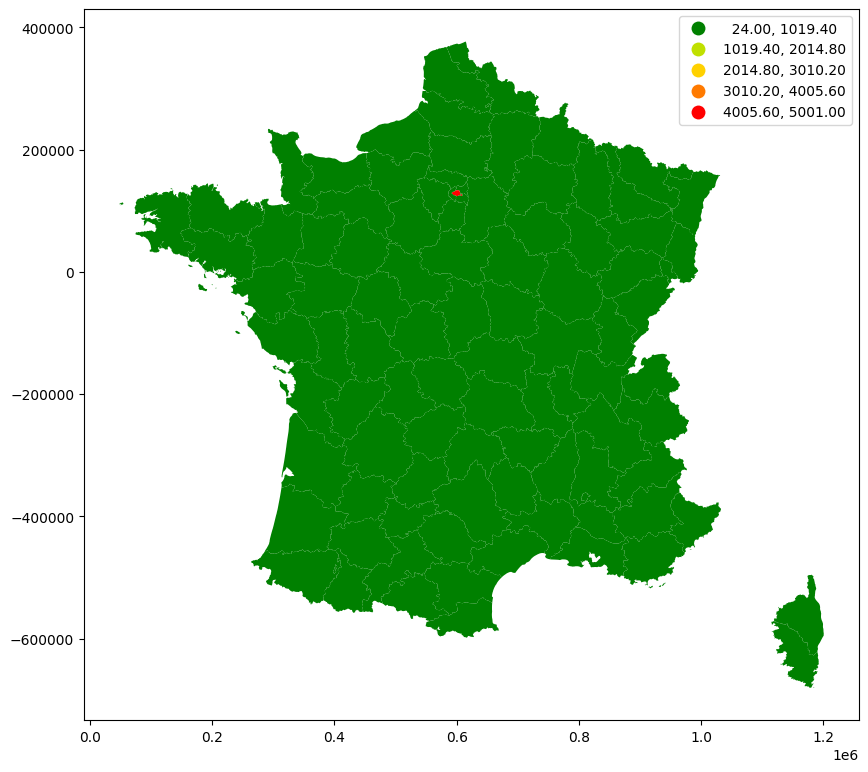

In [25]:
region_by_accidents.plot(column='total',cmap=cmap,scheme='equalinterval',legend=True,figsize=(10,10))
#boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 'jenkscaspall', 'jenkscaspallforced', 
#'jenkscaspallsampled', 'maxp', 'maximumbreaks', 'naturalbreaks', 'quantiles', 'percentiles', 'prettybreaks', 'stdmean', 'userdefined'

# By using equal intervals, the total number of accidents in Paris is way higher than in most regions of france. Let's make the same plot by using region population instead

In [26]:
population = pd.read_excel('../data/TCRD_004.xlsx',index_col=[0])
population_filtered = population[['nom','2023 (p)']].copy().rename(columns = {'2023 (p)':'pop_2023'})
population_filtered

nom  pop_2023
01                      Ain    671937
02                    Aisne    522791
03                   Allier    332443
04  Alpes-de-Haute-Provence    166654
05             Hautes-Alpes    139942
..                      ...       ...
91                  Essonne   1316053
92           Hauts-de-Seine   1642002
93        Seine-Saint-Denis   1682806
94             Val-de-Marne   1426748
95               Val-d'Oise   1274374

[96 rows x 2 columns]

In [27]:
region_by_accidents_pop2023 = region_by_accidents.merge(population_filtered,on='nom')
region_by_accidents_pop2023['acc_per_hab'] = (region_by_accidents_pop2023['total'] / region_by_accidents_pop2023['pop_2023']) * 1000

In [28]:
region_by_accidents_pop2023.sort_values(by=['acc_per_hab'],ascending=[False]).head(10)

code                   nom  \
36   75                 Paris   
21   05          Hautes-Alpes   
82   49        Maine-et-Loire   
60   65       Hautes-Pyrénées   
33   64  Pyrénées-Atlantiques   
55   36                 Indre   
16   68             Haut-Rhin   
84   56              Morbihan   
25   17     Charente-Maritime   
5    35       Ille-et-Vilaine   

                                             geometry  total  pop_2023  \
36  POLYGON ((598781.702 133337.696, 603566.179 13...   5001   2102650   
21  POLYGON ((909410.352 -278534.727, 910653.954 -...    170    139942   
82  POLYGON ((331522.762 14753.942, 332270.240 184...    994    828269   
60  MULTIPOLYGON (((400774.858 -493563.673, 399221...    264    230583   
33  POLYGON ((390674.278 -454989.449, 391301.192 -...    703    697899   
55  POLYGON ((523410.499 -56802.253, 524321.781 -5...    193    214914   
16  POLYGON ((960414.264 79357.239, 962829.090 792...    653    769231   
84  MULTIPOLYGON (((205667.370 -26249.380, 206759....    641    777383   
25  MULTIPOLYGON (((305094.968 -158476.033, 306205...    547    665904   
5   MULTIPOLYGON (((279606.174 105397.241, 276566....    892   1118600   

    acc_per_hab  
36     2.378427  
21     1.214789  
82     1.200093  
60     1.144924  
33     1.007309  
55     0.898034  
16     0.848900  
84     0.824561  
25     0.821440  
5      0.797425

<Axes: >

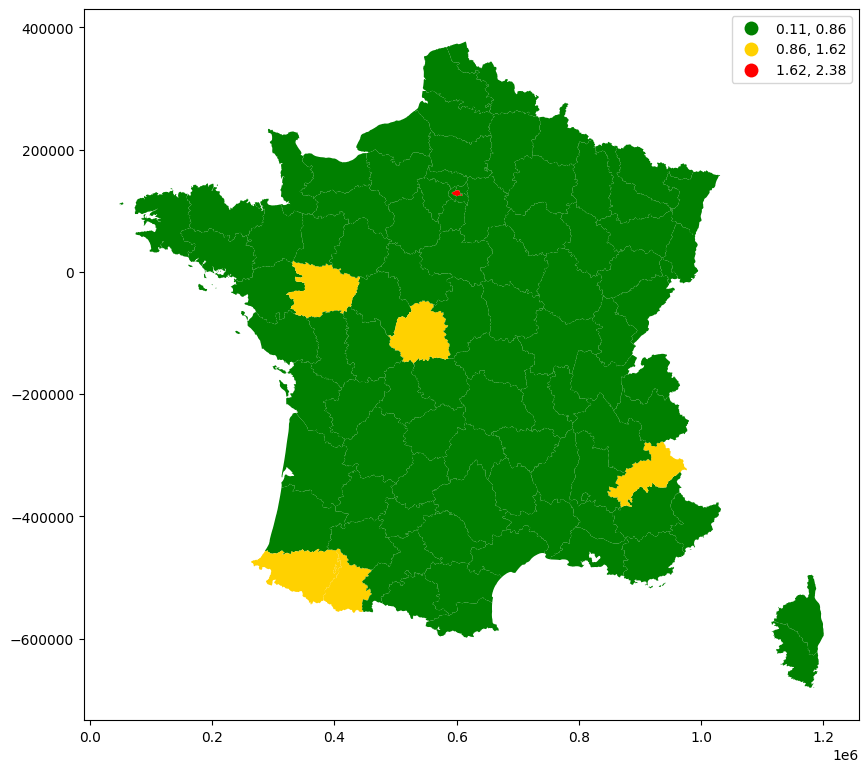

In [29]:
region_by_accidents_pop2023.plot(column='acc_per_hab',scheme='equalinterval',k=3,cmap=cmap,legend=True,figsize=(10,10))

# Maybe the cyclable rods can provide more info

<Axes: >

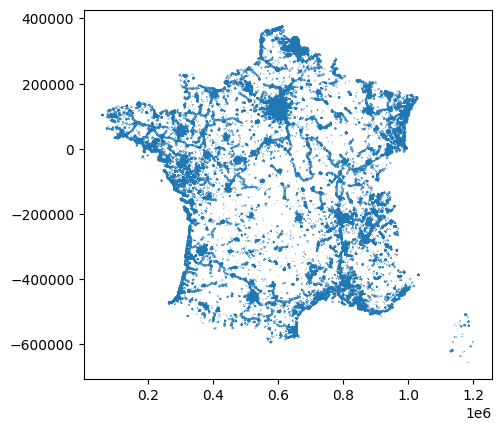

In [30]:
pistes_cyclable = gp.read_file("../data/france-20230901.geojson")
pistes_cyclable = pistes_cyclable.to_crs('epsg:27561')
pistes_cyclable.plot()

In [31]:
pistes_cyclable.head(1)

id_local     id_osm num_iti code_com_d       ame_d regime_d  \
0  geovelo_967104105_65226  967104105     NaN      65226  VOIE VERTE    AUTRE   

            sens_d  largeur_d local_d    statut_d  ... revet_g access_ame  \
0  UNIDIRECTIONNEL        NaN     NaN  EN SERVICE  ...     NaN        NaN   

     date_maj trafic_vit lumiere  d_service                           source  \
0  2021-07-25        5.0     NaN        NaN  Les contributeurs OpenStreetmap   

  project_c        ref_geo                                           geometry  
0      4326  OpenStreetmap  LINESTRING (411941.578 -496613.093, 411959.247...  

[1 rows x 28 columns]

# Check some colums and unique values

In [32]:
ame = pd.Series(u for u in pistes_cyclable['ame_d'].unique())
sens_d = pd.Series(u for u in pistes_cyclable['sens_d'].unique())
revet_g = pd.Series(u for u in pistes_cyclable['revet_g'].unique())
access_ame = pd.Series(u for u in pistes_cyclable['access_ame'].unique())
lumiere = pd.Series(u for u in pistes_cyclable['lumiere'].unique())

In [33]:
df_unique = pd.DataFrame({'track_type': ame, 'track_direction':sens_d,'track_material':revet_g,'track_acess':access_ame,'lumiere':lumiere})
df_unique

track_type  track_direction  \
0                                      VOIE VERTE  UNIDIRECTIONNEL   
1                                           AUTRE   BIDIRECTIONNEL   
2                                           AUCUN              NaN   
3   AMENAGEMENT MIXTE PIETON VELO HORS VOIE VERTE              NaN   
4                                  BANDE CYCLABLE              NaN   
5                                  PISTE CYCLABLE              NaN   
6                                COULOIR BUS+VELO              NaN   
7                                        GOULOTTE              NaN   
8              CHAUSSEE A VOIE CENTRALE BANALISEE              NaN   
9                     ACCOTEMENT REVETU HORS CVCB              NaN   
10                     DOUBLE SENS CYCLABLE BANDE              NaN   
11                                       VELO RUE              NaN   
12                     DOUBLE SENS CYCLABLE PISTE              NaN   
13                                            NaN              NaN   

   track_material    track_acess lumiere  
0             NaN            NaN     NaN  
1           LISSE  VELO DE ROUTE    True  
2         RUGUEUX         ROLLER   False  
3          MEUBLE            VTC     NaN  
4             NaN            VTT     NaN  
5             NaN            NaN     NaN  
6             NaN            NaN     NaN  
7             NaN            NaN     NaN  
8             NaN            NaN     NaN  
9             NaN            NaN     NaN  
10            NaN            NaN     NaN  
11            NaN            NaN     NaN  
12            NaN            NaN     NaN  
13            NaN            NaN     NaN

# Plot proportions of NA for each col

In [34]:
null_track_type_freq = pistes_cyclable['ame_d'].isnull().sum();
not_null_track_type_freq = pistes_cyclable['ame_d'].notnull().sum();

null_track_direction_freq = pistes_cyclable['sens_d'].isnull().sum();
not_null_track_direction_freq = pistes_cyclable['sens_d'].notnull().sum();

null_track_material_freq = pistes_cyclable['revet_g'].isnull().sum();
not_null_track_material_freq = pistes_cyclable['revet_g'].notnull().sum();

null_track_acess_freq = pistes_cyclable['access_ame'].isnull().sum();
not_null_track_acess_freq = pistes_cyclable['access_ame'].notnull().sum();

null_lumiere_freq = pistes_cyclable['lumiere'].isnull().sum();
not_null_lumiere_freq = pistes_cyclable['lumiere'].notnull().sum();

stats = pd.DataFrame({'Col' : ['Track type','Track dir','Track material','Track acess','Lumiere'],
                     'NA': [null_track_type_freq,null_track_direction_freq,null_track_material_freq,null_track_acess_freq,null_lumiere_freq],
                     'Not NA': [not_null_track_type_freq,not_null_track_direction_freq,not_null_track_material_freq,not_null_track_acess_freq,not_null_lumiere_freq]})

stats.set_index('Col')

stats

Col      NA  Not NA
0      Track type      13  293803
1       Track dir      61  293755
2  Track material  110912  182904
3     Track acess  260307   33509
4         Lumiere  223554   70262

# Since there are too many null values regarding track material, acess type and presence of ligtht, let's explore track type and track direction

In [35]:
# Starting by track type

pistes_cyclable_type_not_na = pistes_cyclable.loc[pistes_cyclable['ame_d'].notnull()]
print("Number of track types with null values : ", pistes_cyclable_type_not_na['ame_d'].isnull().sum())

Number of track types with null values :  0


## Visuzalize the top 5 departments by accidents and extract the first one

In [36]:
top5 = region_by_accidents_pop2023.sort_values(by=['acc_per_hab'],ascending=[False]).head(5)
print(top5[['nom','pop_2023']])
paris = top5.head(1)
paris

                     nom  pop_2023
36                 Paris   2102650
21          Hautes-Alpes    139942
82        Maine-et-Loire    828269
60       Hautes-Pyrénées    230583
33  Pyrénées-Atlantiques    697899


code    nom                                           geometry  total  \
36   75  Paris  POLYGON ((598781.702 133337.696, 603566.179 13...   5001   

    pop_2023  acc_per_hab  
36   2102650     2.378427

<Axes: >

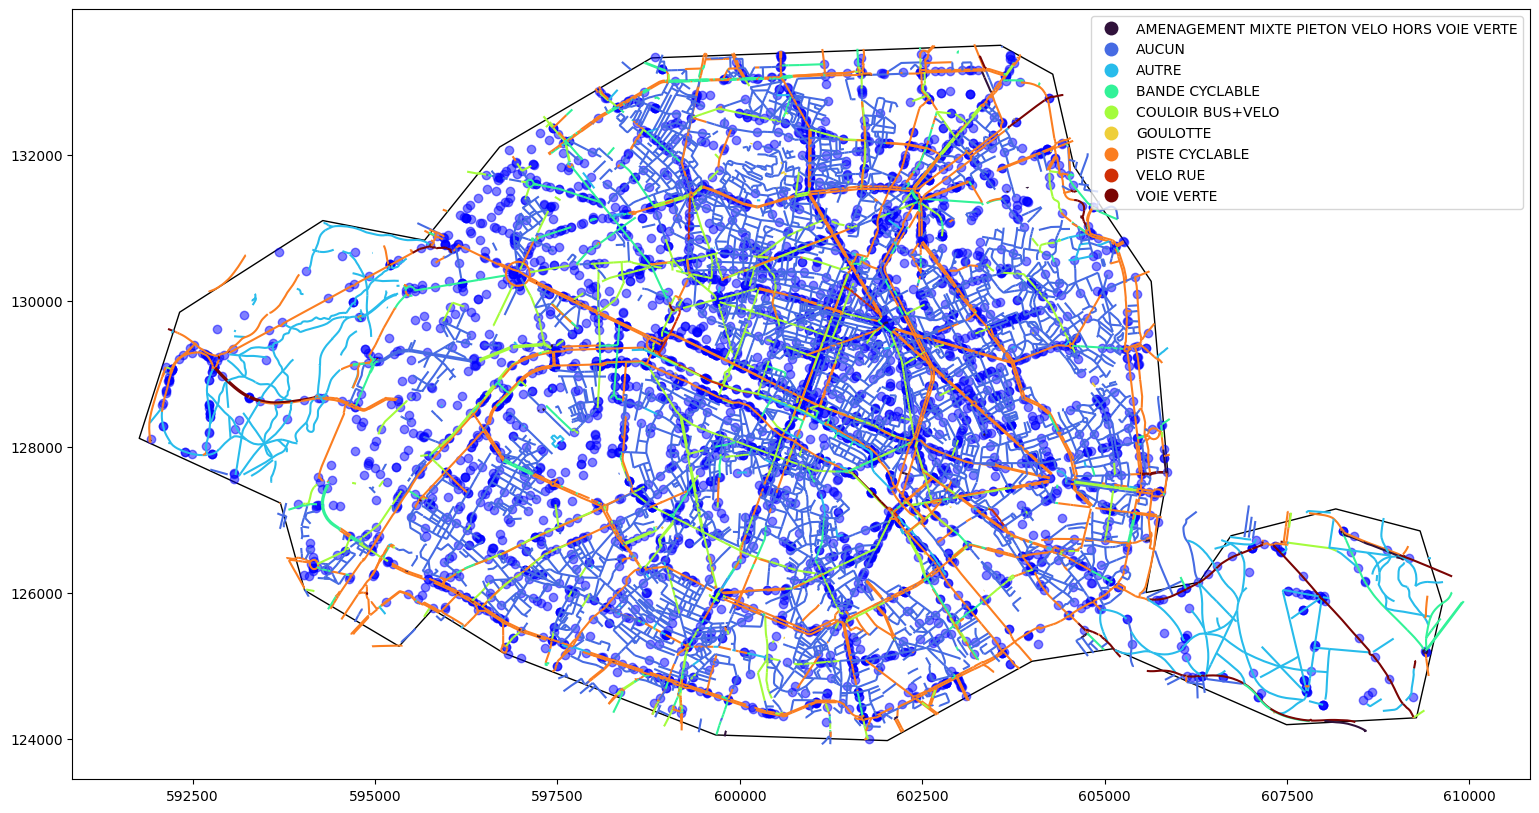

In [37]:

ax = paris.plot(color="white", edgecolor="black", figsize=(20, 10))

# Drop cols with index_ suffix
accidents_by_region_and_name=accidents_by_region_and_name.loc[:,~accidents_by_region_and_name.columns.str.startswith('index_')]
# Intersect tracks with paris
region_intersect_track_type = gp.sjoin(pistes_cyclable_type_not_na, paris, predicate='intersects')
# Intersect accidents with paris
accidents_intersect_type = gp.sjoin(accidents_by_region_and_name, paris, predicate='within')
# Define a colormap
region_intersect_cmap = colors.LinearSegmentedColormap.from_list(region_intersect_track_type["ame_d"].unique(), list(reversed(["green","yellow","orange","red"])))

region_intersect_track_type.plot(ax=ax,cmap='turbo',column='ame_d',legend=True)
accidents_intersect_type.plot(ax=ax,color="blue",legend=True,alpha=0.5)

# There doesnt seem to have a direct relation between accidents and track type. Lets see about the track direction

In [38]:
# Starting by track type

pistes_cyclable_direction_not_na = pistes_cyclable.loc[pistes_cyclable['ame_d'].notnull()]
print("Number of track types with null values : ", pistes_cyclable_direction_not_na['ame_d'].isnull().sum())

Number of track types with null values :  0


/home/paulo/Projects/bike_risk_map/bike_env/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Axes: >

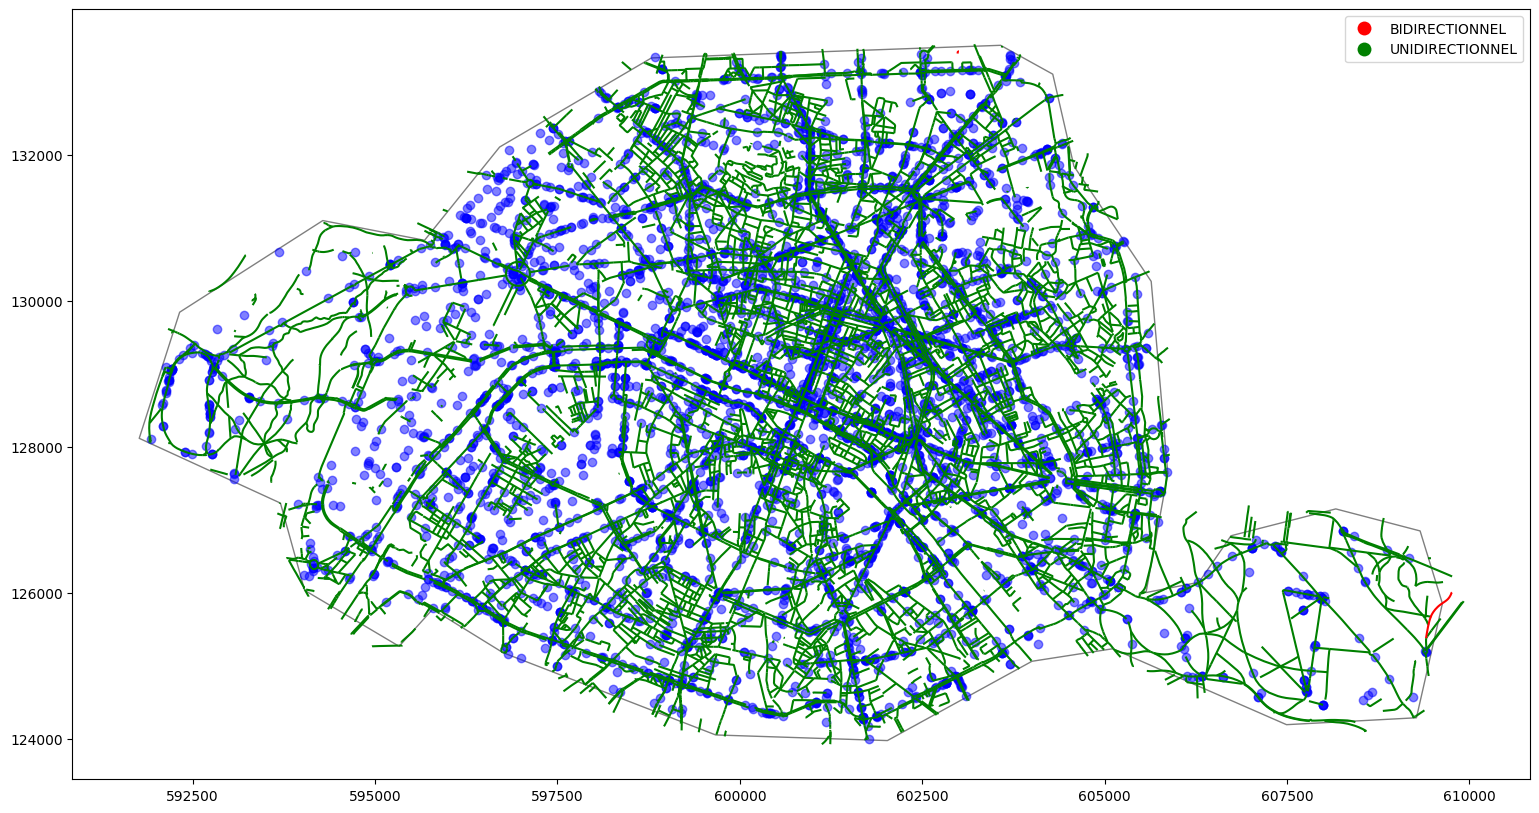

In [39]:
# Intersect tracks with paris

ax = paris.plot(color="white", edgecolor="black",alpha=0.5, figsize=(20, 10))

region_intersect_track_direction = gp.sjoin(pistes_cyclable_direction_not_na, paris, predicate='intersects')
# Intersect accidents with paris
accidents_intersect_track_direction = gp.sjoin(accidents_by_region_and_name, paris, predicate='within')
# Define a colormap
region_intersect_cmap = colors.LinearSegmentedColormap.from_list(region_intersect_track_direction["sens_d"].unique(), list(reversed(["green","red"])))

region_intersect_track_direction.plot(ax=ax,column='sens_d',cmap=region_intersect_cmap,legend=True)
accidents_intersect_track_direction.plot(ax=ax,column="age",color='blue',legend=True,alpha=0.5)



# Accidents by period of the year

In [40]:
months = list(accidents_intersect_track_direction['mois'].unique()).sort
months_order = ['janvier', 'février', 'mars', 'avril',
          'mai', 'juin', 'juillet', 'août',
          'septembre', 'octobre', 'novembre', 'décembre']

In [41]:
accidents_intersect_track_direction_grouped = accidents_intersect_track_direction.sort_values('mois', ascending=True).groupby('mois').size().reset_index(name ='Accidents')

accidents_intersect_track_direction_sorted_grouped = accidents_intersect_track_direction_grouped.sort_values('mois', key=lambda s: s.apply(months_order.index), ignore_index=True)
accidents_intersect_track_direction_sorted_grouped

mois  Accidents
0     janvier        359
1     février        319
2        mars        409
3       avril        391
4         mai        452
5        juin        623
6     juillet        519
7        août        295
8   septembre        507
9     octobre        449
10   novembre        360
11   décembre        318

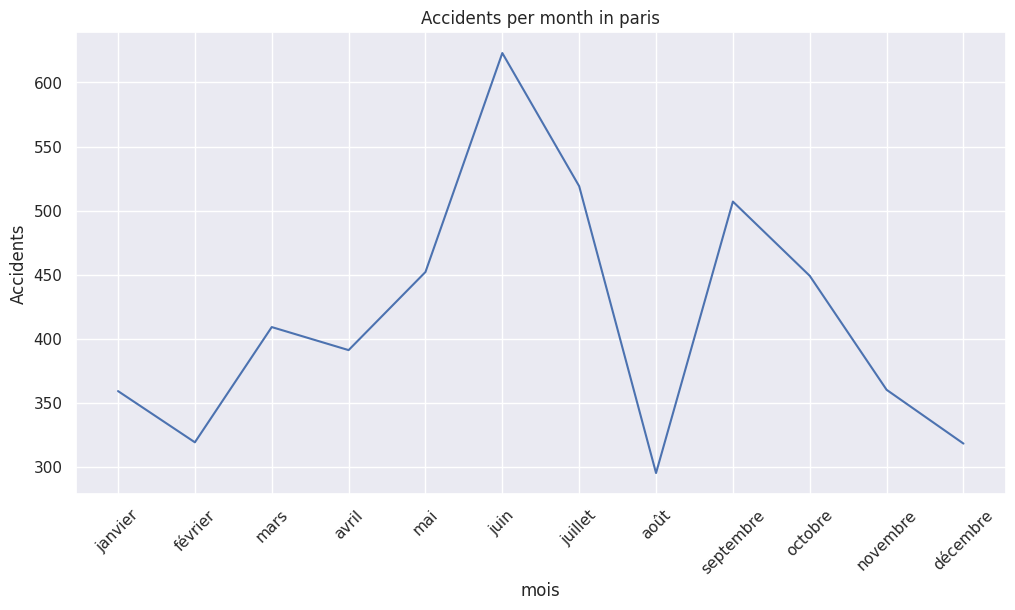

In [42]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=accidents_intersect_track_direction_sorted_grouped, x="mois",y='Accidents').set_title("Accidents per month in paris")
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

# It's cleaar that population has a hight weight on the bicycle , since during the month June and July, we have a incresed number of tourists in Paris. The month of September, is the first after vaccation in France

## Let's make cloroplets, using arrondissement zones in paris

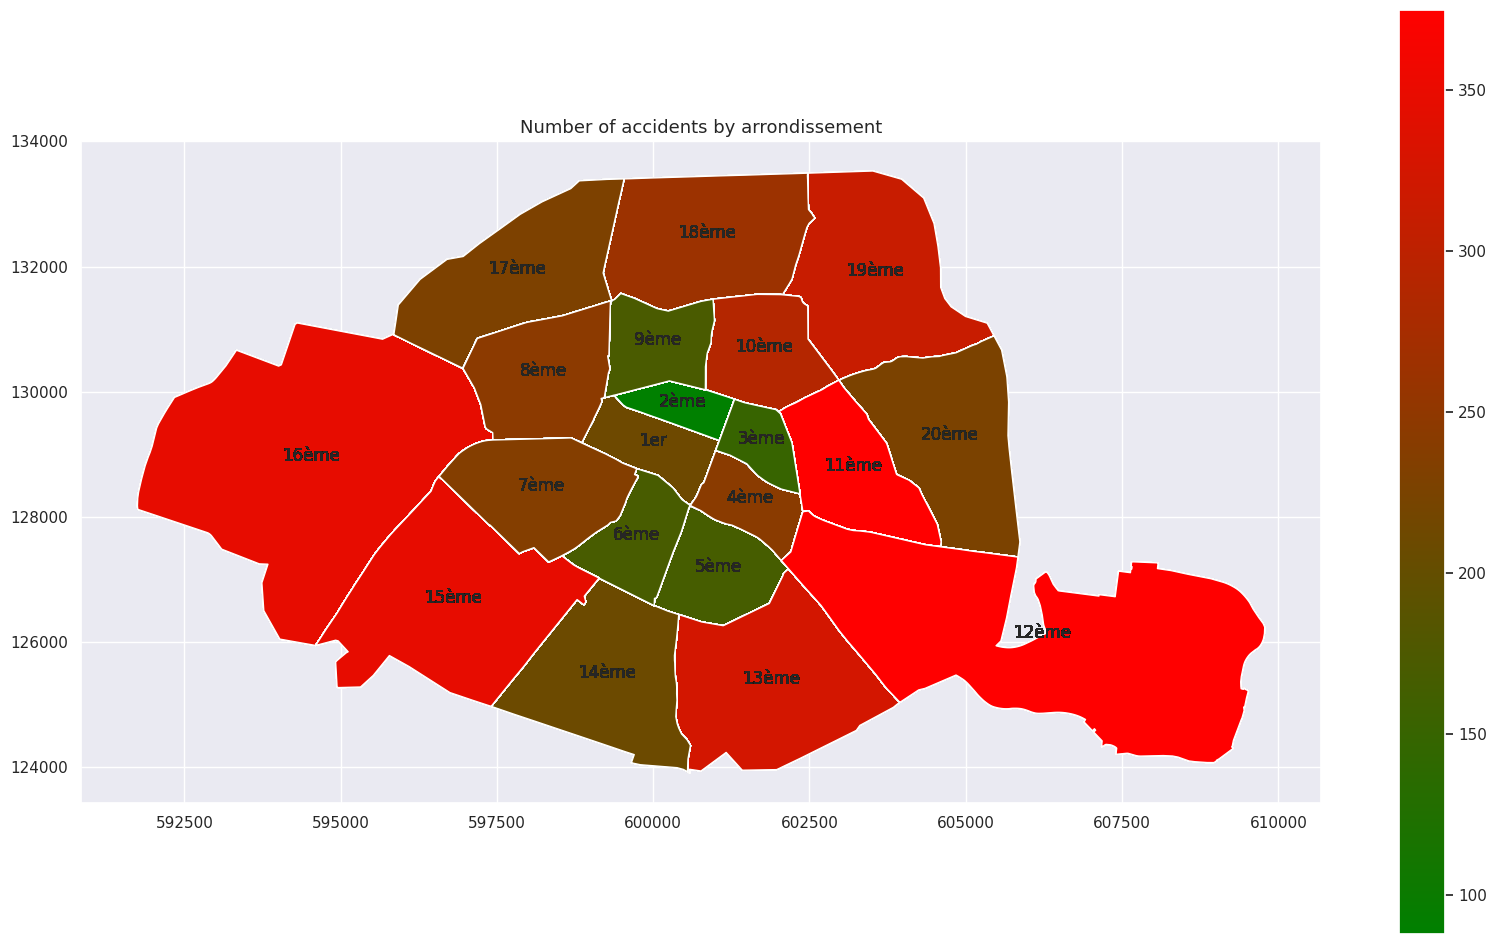

In [43]:
import geoplot as gplt


# Read polygons of arrondissement
arrondis_gdf = gp.read_file("../data/arrondissements.geojson")
arrondis_gdf = arrondis_gdf.to_crs('epsg:27561')

# Drop cols with index_ suffix
#paris_accidents = paris_accidents.loc[:,~paris_accidents.columns.str.startswith('index_')]

# Extract only accidents in paris (by name)
paris_accidents = accidents_by_department.loc[accidents_by_department['nom'] == 'Paris']

# Merge paris accidents with population data and remove cols with index_ (from merge result)
paris_accidents_by_pop2023 = paris_accidents.merge(population_filtered,on='nom')
paris_accidents_by_pop2023 = paris_accidents_by_pop2023.loc[:,~paris_accidents_by_pop2023.columns.str.startswith('index_')]

# Spatial join between arrondissement (polygon) and  accidents in paris (points), using 'intersects predicate
paris_arrondis_accidents_by_pop2023 = gp.sjoin(arrondis_gdf, paris_accidents_by_pop2023, predicate='intersects')

# Group by arronsidement names and merge with popsulation
population_by_arrondissement = paris_arrondis_accidents_by_pop2023.groupby('l_ar').size().reset_index(name='num_accidents')
paris_accidents_by_pop2023_arrondi = paris_arrondis_accidents_by_pop2023.merge(population_by_arrondissement,on='l_ar')

# Ploting result
ax = arrondis_gdf.plot(color="white",edgecolor="black",alpha=0.5, figsize=(20, 12))
paris_accidents_by_pop2023_arrondi.plot(ax=ax,column='num_accidents',cmap=region_intersect_cmap.reversed(),legend=True)

# Plot arrondissement labels based on polygons centroids
paris_accidents_by_pop2023_arrondi.apply(lambda x: ax.annotate(text= x['l_ar'].split(' ')[0], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.set_title('Number of accidents by arrondissement', fontsize=13);

## And plot data

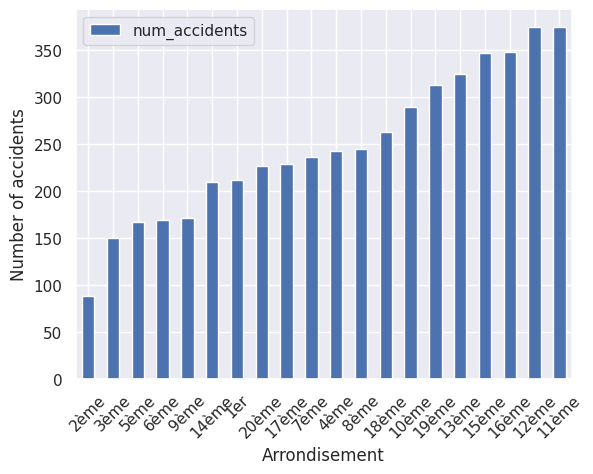

In [44]:
# Order by accident
population_by_arrondissement_ordered = population_by_arrondissement.sort_values('num_accidents')
# Split X axis labels to extract first word
labels = list(population_by_arrondissement_ordered['l_ar'].apply(lambda x: x.split(' ')[0]))

# Define an axis with plot and its parameters
ax = population_by_arrondissement.sort_values('num_accidents').plot(kind='bar',x='l_ar',
                                                               xlabel="Arrondisement",
                                                               ylabel="Number of accidents")
ax.set_xticklabels(labels,rotation=45)

# Plot
plt.show()

## They are not so representative, since we cant see where are the zones where accidents occur more ofter. Lets make a grid

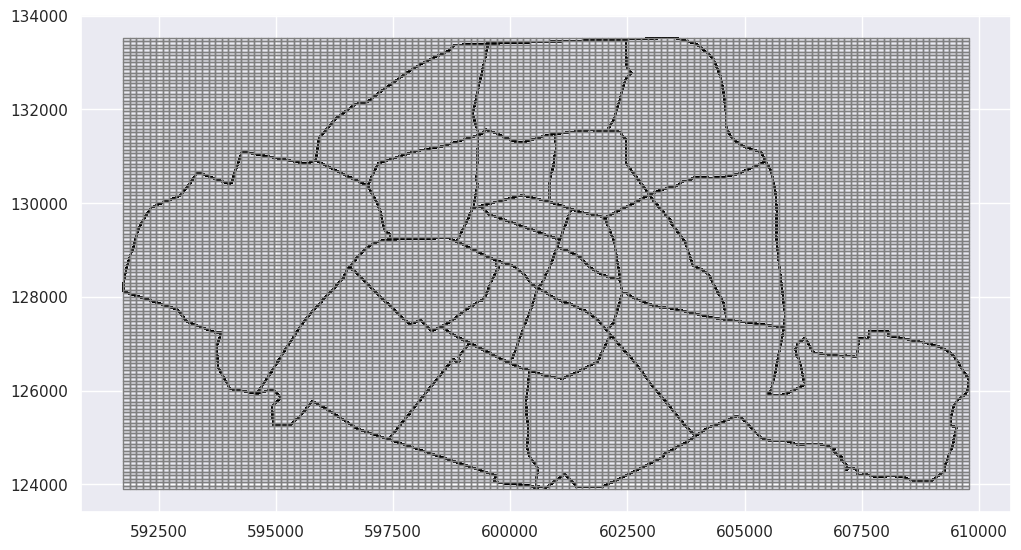

In [45]:
import numpy as np
import shapely

num_cells = 130
a, b, c, d = paris_accidents_by_pop2023_arrondi.total_bounds

# create a grid for Paris
cell_grid = gp.GeoDataFrame(
    geometry=[
        shapely.geometry.box(minx, miny, maxx, maxy)
        for minx, maxx in zip(np.linspace(a, c, num_cells), np.linspace(a, c, num_cells)[1:])
        for miny, maxy in zip(np.linspace(b, d, num_cells), np.linspace(b, d, num_cells)[1:])
    ],
    crs="epsg:27561",
)
ax = paris_accidents_by_pop2023_arrondi.plot(markersize=.1, figsize=(12, 12),alpha=0.5,color="None",edgecolor="black")
plt.autoscale(False)
cell_grid.plot(ax=ax, facecolor="none", edgecolor='grey')
plt.show()

In [46]:
cell_grid["cell_id"] = cell_grid.index + 1
cell_grid.head(5)

geometry  cell_id
0  POLYGON ((591889.700 123898.485, 591889.700 12...        1
1  POLYGON ((591889.700 123973.131, 591889.700 12...        2
2  POLYGON ((591889.700 124047.778, 591889.700 12...        3
3  POLYGON ((591889.700 124122.425, 591889.700 12...        4
4  POLYGON ((591889.700 124197.072, 591889.700 12...        5

## Calculating area of cells

In [98]:
est = (c - a) / num_cells
north = (d - b) / num_cells
total_area = (est * north)
print("Cell area : {:.2f} m2".format(total_area))

Cell area : 10274.43 m2


## Later, we fuse the cells with the accidents layer

## Remove index columns from previous merge operations, if necessary

In [48]:
paris_accidents = paris_accidents.loc[:,~paris_accidents.columns.str.startswith('index_')]
paris_accidents_by_pop2023_arrondi = paris_accidents_by_pop2023_arrondi.loc[:,~paris_accidents_by_pop2023_arrondi.columns.str.startswith('index_')]
print("Dataframes have columns with name index ? :", any(paris_accidents.columns.str.startswith('index_')) 
                                                      and any(paris_accidents_by_pop2023_arrondi.columns.str.startswith('index_')))

Dataframes have columns with name index ? : False


<Axes: >

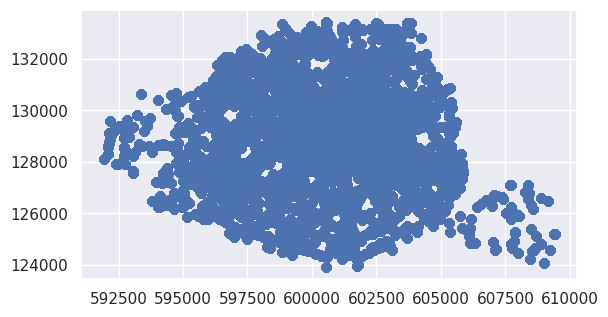

In [49]:
# Grab all dataset of accidents, within paris
accidents_paris = gp.sjoin(accidents_by_region_and_name, paris_accidents_by_pop2023_arrondi, how='inner', predicate='within')
accidents_paris = accidents_paris.loc[:,~accidents_paris.columns.str.startswith('index_')]
accidents_paris.columns = accidents_paris.columns.str.rstrip("_left")
accidents_paris.columns = accidents_paris.columns.str.rstrip("_right")

accidents_paris.plot()

In [50]:
accidents_paris.head()

num_acc          da    an       mois       jou   hrmn dep    com  \
25055  201800041647  2018-01-13  2018    janvier    samedi  21:10  94  94069   
25118  201800054676  2018-03-06  2018       mars     mardi   95:0  75  75120   
25122  201900035012  2019-06-23  2019       juin  dimanche  08:10  75  75112   
25143  202000019957  2020-12-19  2020   décembre    samedi  17:15  94  94033   
25148  202100021295  2021-09-02  2021  septembre     jeudi  08:45  75  75112   

              la       lon  ...  choc  manv       vehiculeid  typevehicules  \
25055  48.817260  2.458920  ...   0.0   1.0  202100048294A01            NaN   
25118  48.846600  2.415980  ...   0.0   1.0  202100048294A01            NaN   
25122  48.844343  2.441665  ...   0.0   1.0  202100048294A01            NaN   
25143  48.844350  2.450700  ...   0.0   1.0  202100048294A01            NaN   
25148  48.818409  2.451584  ...   0.0   1.0  202100048294A01            NaN   

       manoeuvehicules  numvehicules  code    nom  pop_2023  num_accidents  
25055              NaN           NaN    75  Paris   2102650            375  
25118              NaN           NaN    75  Paris   2102650            375  
25122              NaN           NaN    75  Paris   2102650            375  
25143              NaN           NaN    75  Paris   2102650            375  
25148              NaN           NaN    75  Paris   2102650            375  

[5 rows x 95 columns]

In [51]:
##################################################################################################
##################################################################################################

## Plot accidents by arrodissedement groupped by zone

In [53]:
#######
# Perform spatial join, merging attribute table of wells point and that of the cell with which it intersects
# op = "intersects" also counts those that fall on a cell boundary (between two cells)
# op = "within" will not count those fall on a cell boundary

points_within=points_within.loc[:,~points_within.columns.str.startswith('index_')]

grid_accidents = gp.sjoin(points_within, cell_grid, how='left', op='within')

# Remove duplicate counts
# With intersect, those that fall on a boundary will be allocated to all cells that share that boundary

# Add a field with constant value of 1
grid_accidents['n_acc'] = 1

# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = grid_accidents.dissolve(by="index_right", aggfunc="count")

# put this into cell
cell_grid.loc[dissolve.index, 'n_acc'] = dissolve.n_acc.values

# Fill the NaN values (cells without any points) with 0
#cell_grid['n_acc'] = cell_grid['n_acc'].fillna(0)
#cell_grid = cell_grid.within(paris_accidents_by_pop2023_arrondi)]


/home/paulo/Projects/bike_risk_map/bike_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


1.0

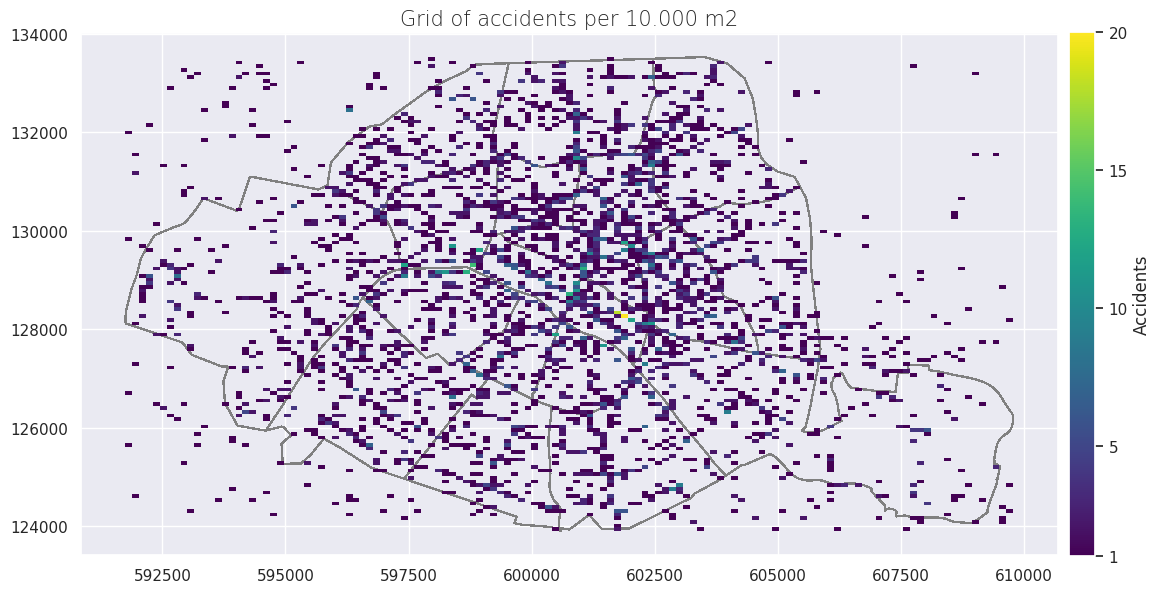

In [160]:
# Plot data
ax = paris_accidents_by_pop2023_arrondi.plot(markersize=.1, figsize=(15, 10),alpha=0.1,color="None",edgecolor="gray")
legend_intervals = [int(cell_grid["n_acc"].min()),5,10,15,int(cell_grid["n_acc"].max())]
cell_grid.plot(ax = ax, column = "n_acc", 
                cmap='viridis',edgecolor="none", legend = True,
                legend_kwds={
                    "shrink":.68,
                    "format": "%g",
                    'label': "Accidents",
                    "pad": 0.01,
                    "ticks" : legend_intervals
                })
# Set title
ax.set_title('Grid of accidents per 10.000 m2', fontdict = {'fontsize': '15', 'fontweight' : '3'})
plt.show()

# Lets test some interpolation methods to fill the empty cells and get better results

## Give a small subset of points to train on

In [178]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)

# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

In [252]:
# To make it interesting, we only give a small subset of points to train on.
samples = cell_grid["n_acc"].sample(100)
samples.fillna(0,inplace=True)
samples = samples.to_list()


x_train =  samples
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

In [253]:
x_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

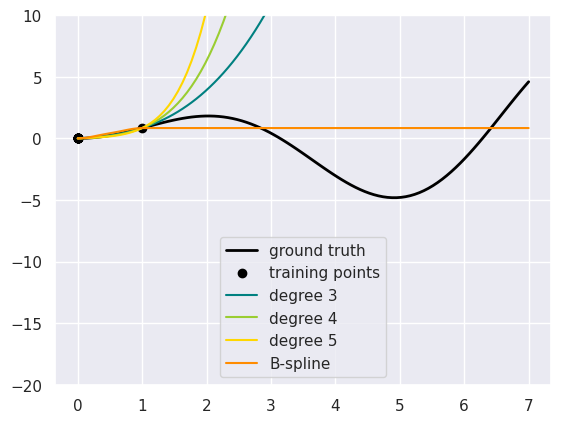

In [254]:

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()
